# Mount and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
import string
import nltk
import pickle
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, StringLookup, Embedding, Input, Dense, Flatten, Embedding, SimpleRNN, LSTM, Dropout, add, BatchNormalization, TimeDistributed
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16 , InceptionV3, vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from google.colab import drive

# Task 1

In [ ]:
# ─── Dataset configuration ─────────────────────────────────────────────────────
base_dir = '/content/drive/MyDrive/Assignment2/team_08_image'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

class_names = ['n01440764', 'n01632777', 'n01776313', 'n02011460', 'n02051845']

In [ ]:
img_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze layers for faster training

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc:.4f}')


Found 2800 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 746s 8s/step - accuracy: 0.5217 - loss: 1.3246 - val_accuracy: 0.8329 - val_loss: 0.4967
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 730s 8s/step - accuracy: 0.8201 - loss: 0.5112 - val_accuracy: 0.8600 - val_loss: 0.4361
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 729s 8s/step - accuracy: 0.8518 - loss: 0.4139 - val_accuracy: 0.8814 - val_loss: 0.3770
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 734s 8s/step - accuracy: 0.8933 - loss: 0.3120 - val_accuracy: 0.8786 - val_loss: 0.3510
Epoch 5/10
 2/88 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - accuracy: 0.8516 - loss: 0.3472

KeyboardInterrupt: 

In [ ]:
# ─── Data generators ───────────────────────────────────────────────────────────
img_size = 299  # InceptionV3 requires 299x299 input
batch_size = 64  # Increased batch size for faster training

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    subset='validation'
)


In [ ]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # More efficient than Flatten
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Task 2

In [ ]:
# ─── Dataset configuration ─────────────────────────────────────────────────────
base_dir   = '/content/drive/MyDrive/Assignment2/team_08_image'
train_dir  = os.path.join(base_dir, 'train')
test_dir   = os.path.join(base_dir, 'test')

class_names = ['n01440764','n01632777','n01776313','n02011460','n02051845' ]

In [ ]:
# ─── Data generators ───────────────────────────────────────────────────────────
img_size   = 299     # keep the same input size
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# ─── Build CL1→PL1→CL2→PL2 CNN ─────────────────────────────────────────────
model = models.Sequential([
    # CL1: 4 filters, 3×3 kernel, stride 1
    layers.Conv2D(filters=4, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(img_size, img_size, 3)),
    # PL1: mean (average) pooling 2×2, stride 2
    layers.AveragePooling2D(pool_size=(2,2), strides=2),
    # CL2: 8 filters, 3×3 kernel, stride 1
    layers.Conv2D( filters=8, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # PL2: mean pooling 2×2, stride 2
    layers.AveragePooling2D(pool_size=(2,2), strides=2),
    # Flatten & head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ─── Train ────────────────────────────────────────────────────────────────────
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)

# ─── Evaluate ─────────────────────────────────────────────────────────────────
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')


Found 2800 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 4)         │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 149, 149, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 8)         │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 74, 74, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43808)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       2,803,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,804,509 (10.70 MB)

 Trainable params: 2,804,509 (10.70 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
31/43 ━━━━━━━━━━━━━━━━━━━━ 2:59 15s/step - accuracy: 0.2407 - loss: 1.5577

KeyboardInterrupt: 

# Task 3

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Assignment2/Team_8_POS/train.csv'
GLOVE_PATH = '/content/drive/MyDrive/Assignment2/glove.6B.200d.txt'

In [ ]:
#GloVe Embeddings Loader
def load_glove():
    embeddings = {}
    with open(GLOVE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [ ]:
# Tokenization
def preprocess(text):
    return text.lower().split()

In [ ]:
# Padding
def pad_sequence(seq, length, pad_val):
    return seq + [pad_val] * (length - len(seq))

In [ ]:
#Custom Training Setup
def masked_loss(y_true, y_pred):
    loss = SparseCategoricalCrossentropy(reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

In [ ]:
class MaskedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="masked_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_ids = tf.argmax(y_pred, axis=-1)
        matches = tf.cast(tf.equal(y_true, pred_ids), tf.float32)
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        self.total.assign_add(tf.reduce_sum(matches * mask))
        self.count.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.total / (self.count + 1e-8)

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

In [ ]:
#Inference Function
def predict_pos(sentence):
    tokens = preprocess(sentence)[:128]
    padded = [''] * 128
    padded[:len(tokens)] = tokens
    vec = vectorizer([' '.join(padded)])
    pred = model.predict(vec)[0]
    return [(t, tag_lookup.get_vocabulary()[np.argmax(p)])
            for t, p in zip(tokens, pred[:len(tokens)])]

In [ ]:
glove_embeddings = load_glove()
df = pd.read_csv(DATA_PATH)

sentences = [preprocess(s)[:128] for s in df['Sentence'].astype(str)]
tags = [preprocess(t)[:128] for t in df['Tags'].astype(str)]

padded_sentences = [' '.join(pad_sequence(s, 128, '')) for s in sentences]
padded_tags = [pad_sequence(t, 128, '<PAD>') for t in tags]

#Text Vectorization with GloVe Integration
vectorizer = TextVectorization(
    max_tokens=20000,
    output_sequence_length=128,
    standardize='lower_and_strip_punctuation'
)

vectorizer.adapt(padded_sentences)
vocab = vectorizer.get_vocabulary()

embedding_matrix = np.zeros((len(vocab), 200))
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        embedding_matrix[i] = glove_embeddings[word]

#Tag Encoding
unique_tags = sorted({tag for seq in tags for tag in seq} - {'<PAD>'})
tag_lookup = StringLookup(
    vocabulary=['<PAD>'] + unique_tags,
    mask_token='<PAD>',
    num_oov_indices=0
)

#Model Architecture (200D GloVe + 25-unit RNN)
inputs = Input(shape=(128,), dtype=tf.int32)
# GloVe Embedding Layer
x = Embedding( input_dim=len(vocab), output_dim=200, weights=[embedding_matrix], trainable=False, mask_zero=True)(inputs)
# 25-unit RNN Layer
x = SimpleRNN(25, return_sequences=True)(x)
outputs = Dense(len(tag_lookup.get_vocabulary()), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss=masked_loss,
    metrics=[MaskedAccuracy()]
)

#Training Execution
X = vectorizer(padded_sentences).numpy()
y = tag_lookup(padded_tags).numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

print("\nExample Prediction:")
print(predict_pos("The quick brown fox jumps over the lazy dog"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully

Loading GloVe embeddings...
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 2.0496 - masked_accuracy: 0.2208 - val_loss: 1.6679 - val_masked_accuracy: 0.3618
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 1.6135 - masked_accuracy: 0.3726 - val_loss: 1.5655 - val_masked_accuracy: 0.3842
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 1.5338 - masked_accuracy: 0.3880 - val_loss: 1.5135 - val_masked_accuracy: 0.3958
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 1.4790 - masked_accuracy: 0.4041 - val_loss: 1.4826 - val_masked_accuracy: 0.3995
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 1.4624 - masked_accuracy: 0.4063 - val_loss: 1.4623 - val_masked_accuracy: 0.4058
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 1.4127 - masked_accurac

# Task 4

In [ ]:
try:
    nltk.data.find('corpora/treebank')
except nltk.downloader.DownloadError:
    print("Downloading NLTK treebank corpus...")
    nltk.download('treebank')
    nltk.download('universal_tagset') # Use universal tagset for simplicity

# ================= Configuration =================
MAX_LENGTH = 100      # Max sequence length for words/tags
EMBEDDING_DIM = 200  # GloVe embedding dimension
RNN_UNITS = 25       # Number of units in the SimpleRNN hidden layer
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.1 # Percentage of training data to use for validation during fit
BATCH_SIZE = 64
EPOCHS = 15

In [ ]:
def load_glove():
    embeddings = {}
    with open(GLOVE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [ ]:
glove_embeddings = load_glove()
tagged_sentences = nltk.corpus.treebank.tagged_sents(tagset='universal')

# Prepare Data for Sequence Model
sentences, tag_sequences = [], []
for sent in tagged_sentences:
    words, tags = zip(*sent) # Unzip words and tags
    sentences.append(list(words))
    tag_sequences.append(list(tags))

word_counts = nltk.FreqDist(word for sent in sentences for word in sent)
VOCAB_SIZE_WORDS = len(word_counts) + 2
print(f"Total unique words found: {len(word_counts)}")

# Create mappings, reserving 0 for padding and 1 for unknowns
word_to_idx = {word: i+2 for i, word in enumerate(word_counts.keys())}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1
idx_to_word = {i: word for word, i in word_to_idx.items()}
print(f"Word vocabulary size (incl. PAD/UNK): {len(word_to_idx)}")

# Create Tag Vocabulary and Mappings
unique_tags = set(tag for seq in tag_sequences for tag in seq)
# Reserve 0 for padding tag
tag_to_idx = {tag: i+1 for i, tag in enumerate(sorted(list(unique_tags)))}
tag_to_idx['<PAD>'] = 0
idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}
NUM_TAGS = len(tag_to_idx)
print(f"\nUnique POS Tags found: {len(unique_tags)}")
print(f"Tag vocabulary size (incl. PAD): {NUM_TAGS}")
print("Tags:", unique_tags)
print("Tag mapping:", tag_to_idx)

# Convert sentences and tags to integer sequences
X = [[word_to_idx.get(word, word_to_idx['<UNK>']) for word in sent] for sent in sentences]
y = [[tag_to_idx[tag] for tag in tag_seq] for tag_seq in tag_sequences]

# Pad sequences
print(f"\nPadding sequences to max length: {MAX_LENGTH}")
X_padded = pad_sequences(X, maxlen=MAX_LENGTH, padding='post', value=word_to_idx['<PAD>'])
y_padded = pad_sequences(y, maxlen=MAX_LENGTH, padding='post', value=tag_to_idx['<PAD>']) # Pad tags with 0


print("Shape of X_padded:", X_padded.shape)
print("Shape of y_padded:", y_padded.shape)
print("Example X_padded[0]:", X_padded[0][:20]) # Show first 20 tokens
print("Example y_padded[0]:", y_padded[0][:20]) # Show first 20 tags


# Create Embedding Matrix using GloVe
print("\nCreating Embedding Matrix...")
word_vocab_size = len(word_to_idx)
embedding_matrix = np.zeros((word_vocab_size, EMBEDDING_DIM))
hits = 0
misses = 0

if glove_embeddings:
    for word, i in word_to_idx.items():
        if i == 0: continue
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            embedding_vector_lower = glove_embeddings.get(word.lower())
            if embedding_vector_lower is not None:
                 embedding_matrix[i] = embedding_vector_lower
                 hits +=1
            else:
                 embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
                 misses += 1
    print(f"Converted {hits} words to GloVe vectors ({misses} misses).")
else:
    print("Warning: No GloVe embeddings loaded. Using random initialization for Embedding layer.")
    embedding_matrix = np.random.normal(scale=0.6, size=(word_vocab_size, EMBEDDING_DIM))
    GLOVE_TRAINABLE = True # Override later

GLOVE_TRAINABLE = False if glove_embeddings else True
print(f"Embedding layer trainable: {GLOVE_TRAINABLE}")

print("\nBuilding the POS Tagging Model...")

input_layer = Input(shape=(MAX_LENGTH,), name="word_indices")
embedding_layer = Embedding( input_dim=word_vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=GLOVE_TRAINABLE, mask_zero=True, name="glove_embedding")(input_layer)
rnn_layer = SimpleRNN( RNN_UNITS, return_sequences=True, name="simple_rnn_layer" )(embedding_layer)
output_layer = TimeDistributed( Dense(NUM_TAGS, activation='softmax'), name="tag_output" )(rnn_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    weighted_metrics=['accuracy']
)
model.summary()
print("\nSplitting data and starting training...")
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=TEST_SPLIT, random_state=42)
history = model.fit(
    X_train, y_train,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy (ignoring padding): {test_accuracy:.4f}")



TensorFlow version: 2.18.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Loaded 400000 GloVe vectors
Dataset loaded successfully:
      id sentiment                                              tweet
0  19069  Negative  that feeling when the kiln is clicking away as...
1  31231  Negative   @user @user and the @user getting prepped for...
2  24905  Positive  @user powerful women work for trump !!!  racis...
3   5212  Negative  @user rip heaps! i'm going to miss you. we had...
4  17312  Negative  a #doodle for my #iphone #doolemyway #doodleri...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 150)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 150, 200)            │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 25)                  │           5,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,076 (23.73 KB)

 Trainable params: 5,676 (22.17 KB)

 Non-trainable params: 400 (1.56 KB)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
def predict_pos_tags(sentences_list):
    if not isinstance(sentences_list, list):
        sentences_list = [sentences_list]
    results = []
    for sentence in sentences_list:
        words = nltk.word_tokenize(sentence)
        word_indices = [word_to_idx.get(w, word_to_idx['<UNK>']) for w in words]
        padded_indices = pad_sequences([word_indices], maxlen=MAX_LENGTH, padding='post', value=word_to_idx['<PAD>'])
        predictions = model.predict(padded_indices, verbose=0) # Shape: (1, MAX_LENGTH, NUM_TAGS)
        predicted_tag_indices = np.argmax(predictions[0], axis=1) # Shape: (MAX_LENGTH,)
        predicted_tags = [idx_to_tag.get(idx) for idx in predicted_tag_indices[:len(words)]] # Only take tags for actual words
        results.append(list(zip(words, predicted_tags)))
    return results


In [ ]:
print("\n--- Example Prediction ---")
example_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "This is a test sentence for the POS tagger.",
    "Programming with TensorFlow and Keras is fun."
]
predictions = predict_pos_tags(example_sentences)
for sentence_result in predictions:
    print(sentence_result)

# Task 5 and 6

In [ ]:
NUM_IMAGES_TO_USE = 8097
BASE_DRIVE_PATH = '/content/drive/MyDrive/Assignment2/Team8_captioning/'

In [ ]:
DECODER_TYPE = 'rnn' # Options: 'rnn' or 'lstm'

In [ ]:
CAPTIONS_PATH = os.path.join(BASE_DRIVE_PATH, 'captions.txt')
IMAGES_PATH = os.path.join(BASE_DRIVE_PATH, 'Images')
FEATURES_PATH = os.path.join(BASE_DRIVE_PATH, f'vgg16_features_{DECODER_TYPE}.pkl')
MODEL_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, f'caption_model_{DECODER_TYPE}_lim{NUM_IMAGES_TO_USE}.keras')
TOKENIZER_PATH = os.path.join(BASE_DRIVE_PATH, f'tokenizer_{DECODER_TYPE}_lim{NUM_IMAGES_TO_USE}.pkl')

# Model Parameters
EMBEDDING_DIM = 256
UNITS = 50
VOCAB_SIZE_LIMIT = 5000
MAX_LENGTH_PADDING = 35
BATCH_SIZE = 320
EPOCHS = 15
DROPOUT_RATE = 0.3
RNN_LSTM_DROPOUT = 0.2

# Image Params
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Loading

In [ ]:
# Load and Prepare Captions
def load_captions(filename):
    mapping = {}
    parsed_count = 0
    line_num = 0
    error_lines = 0
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                line_num += 1
                line = line.strip()
                if not line: continue

                match_separator = re.search(r'[#.]\d+\s+', line)

                if match_separator:
                    separator_start_index = match_separator.start()
                    separator_end_index = match_separator.end()
                    image_id = line[:separator_start_index].strip()
                    caption = line[separator_end_index:].strip()

                    if not image_id or ' ' in image_id or '\t' in image_id:
                        error_lines += 1
                        continue

                    if image_id not in mapping:
                        mapping[image_id] = []
                    mapping[image_id].append(caption)
                    parsed_count += 1

                else:
                     error_lines += 1

    except FileNotFoundError:
        print(f"Error: Caption file not found at {filename}")
        return None
    except Exception as e:
         print(f"An unexpected error occurred during caption loading (around line {line_num}): {e}")
         return None

    total_lines_processed = line_num
    num_unique_images = len(mapping)
    print(f"\n--- Caption Loading Summary ---")
    print(f"Processed {total_lines_processed} lines from {filename}.")
    print(f"Successfully parsed captions for {num_unique_images} unique images.")
    print(f"Total caption entries added: {sum(len(v) for v in mapping.values())}")
    if error_lines > 0:
         print(f"Encountered {error_lines} problematic lines that couldn't be fully parsed.")
    elif total_lines_processed > 0 and num_unique_images == 0:
         print("Warning: No captions were loaded. Check file content and parsing logic.")

    return mapping

In [ ]:
def clean_captions(mapping):
    translator = str.maketrans('', '', string.punctuation)
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.translate(translator)
            caption = ' '.join(caption.split())
            captions[i] = '<start> ' + caption + ' <end>'
    print("Captions cleaned (lowercase, punctuation removed, start/end tokens added).")

captions_dict_all = load_captions(CAPTIONS_PATH) # Load all initially
if captions_dict_all:
    clean_captions(captions_dict_all)


--- Caption Loading Summary ---
Processed 40460 lines from /content/drive/MyDrive/Assignment2/Team8_captioning/captions.txt.
Successfully parsed captions for 8092 unique images.
Total caption entries added: 40460
Captions cleaned (lowercase, punctuation removed, start/end tokens added).


In [ ]:
def preprocess_image(img_path):
    try:
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg16.preprocess_input(img)
        return img
    except Exception as e:
        return None


## Extraction

In [ ]:
def extract_features(image_dir, image_ids_to_process, force_rerun=False, existing_features_path=None):
    loaded_features = {}
    if not force_rerun and existing_features_path and os.path.exists(existing_features_path):
        print(f"Attempting to load pre-computed features from: {existing_features_path}")
        try:
            with open(existing_features_path, 'rb') as f:
                loaded_features = pickle.load(f)
            print(f"Loaded {len(loaded_features)} features from cache.")
        except Exception as e:
             print(f"Error loading feature file {existing_features_path}, will proceed with extraction. Error: {e}")
             loaded_features = {}
    else:
        if not force_rerun and existing_features_path:
            print(f"Feature file not found at {existing_features_path} or rerun forced. Will extract needed features.")
        loaded_features = {}


    final_features = {}
    ids_needing_extraction = []
    ids_found_in_cache = 0

    for img_id in image_ids_to_process:
        if img_id in loaded_features:
             final_features[img_id] = loaded_features[img_id]
             ids_found_in_cache +=1
        else:
             ids_needing_extraction.append(img_id)

    print(f"Required images: {len(image_ids_to_process)}. Found in cache: {ids_found_in_cache}. Need to extract: {len(ids_needing_extraction)}.")

    if not ids_needing_extraction:
         print("All required features were found in the cache.")
         return final_features # Return only the subset needed


    print(f"Extracting features using VGG16 for {len(ids_needing_extraction)} images...")
    vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling='avg')

    error_count = 0
    newly_extracted_count = 0
    for img_id in tqdm(ids_needing_extraction, desc="Extracting Features"):
        img_path = os.path.join(image_dir, img_id)
        if not os.path.exists(img_path):
            error_count += 1
            continue

        img = preprocess_image(img_path)
        if img is None:
           error_count += 1
           continue

        try:
          feature = vgg_model.predict(img, verbose=0)
          final_features[img_id] = np.squeeze(feature) # Add extracted feature
          newly_extracted_count += 1
        except Exception as e:
          error_count += 1

    print(f"Feature extraction complete. {newly_extracted_count} new features extracted, {error_count} errors encountered.")

    if newly_extracted_count > 0 and existing_features_path:
        print(f"Updating feature cache file at {existing_features_path}...")
        try:
            features_to_save = loaded_features
            features_to_save.update(final_features)

            with open(existing_features_path, 'wb') as f:
                pickle.dump(features_to_save, f)
            print(f"Features cache updated.")
        except Exception as e:
            print(f"Error saving/updating features cache: {e}")

    return final_features


Found 8092 unique image IDs mentioned in /content/drive/MyDrive/Assignment2/Team8_captioning/captions.txt.
Found 8091 corresponding image files in the 'Images' folder.
Using all 8091 available valid images (limit 8097 >= available).
Processing will be based on 8091 images.
Filtered captions dictionary to 8091 entries matching the selected image subset.
Attempting to load pre-computed features from: /content/drive/MyDrive/Assignment2/Team8_captioning/vgg16_features_rnn.pkl
Loaded 100 features from cache.
Required images: 8091. Found in cache: 100. Need to extract: 7991.
Extracting features using VGG16 for 7991 images...


Extracting Features:   0%|          | 0/7991 [00:00<?, ?it/s]

Feature extraction complete. 7991 new features extracted, 0 errors encountered.
Updating feature cache file at /content/drive/MyDrive/Assignment2/Team8_captioning/vgg16_features_rnn.pkl...
Features cache updated.
Retained features for 8091 images after extraction/loading.

Extracted/Loaded Feature Dimension: 512

Total number of captions for tokenization (from subset): 40455
Vocabulary Size (limit 5000): 5001
Maximum actual sequence length found (in subset): 38
Using max sequence length: 38
Tokenizer saved to: /content/drive/MyDrive/Assignment2/Team8_captioning/tokenizer_rnn_lim8097.pkl
Created 476960 input-output pairs from subset for training.

Splitting 8091 selected image samples:
Train images: 6474, Validation images: 1213, Test images: 404
Train pairs created: 381826, Validation pairs created: 71632
Building SimpleRNN model for single word prediction.

--- Model Summary (RNN) ---


Model: "image_captioning_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caption_input             │ (None, 38)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_features            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 38, 256)        │      1,280,256 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 38, 256)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 50)             │         25,650 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ (None, 50)             │         15,350 │ dropout_5[0][0],       │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 5001)           │        255,051 │ simple_rnn_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,576,307 (6.01 MB)

 Trainable params: 1,576,307 (6.01 MB)

 Non-trainable params: 0 (0.00 B)


Train generator length: 1193 batches
Validation generator length: 223 batches

--- Starting Training ---
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1247 - loss: 5.7234
Epoch 1: val_loss improved from inf to 5.31941, saving model to /content/drive/MyDrive/Assignment2/Team8_captioning/caption_model_rnn_lim8097.keras
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 212s 175ms/step - accuracy: 0.1247 - loss: 5.7231 - val_accuracy: 0.1344 - val_loss: 5.3194
Epoch 2/15
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.1309 - loss: 5.3208
Epoch 2: val_loss improved from 5.31941 to 5.31817, saving model to /content/drive/MyDrive/Assignment2/Team8_captioning/caption_model_rnn_lim8097.keras
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 206s 173ms/step - accuracy: 0.1309 - loss: 5.3208 - val_accuracy: 0.1344 - val_loss: 5.3182
Epoch 3/15
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1322 - loss: 5.3158
Epoch 3: val_loss did not improve from 5.31817
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 208s 175ms/step - accuracy: 0.1322 - loss: 5.3158 - val_accuracy: 0.1344 - val_loss: 5.3185
Epoch 4/15
1193/1193 ━━━━

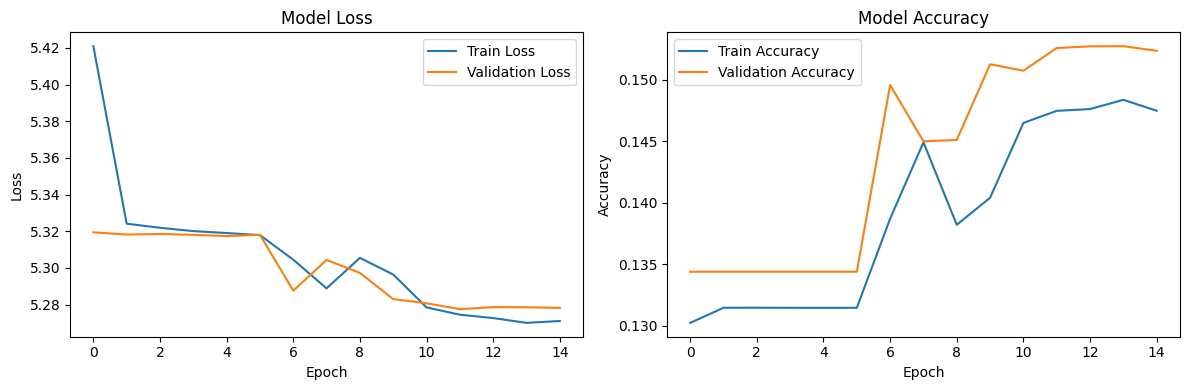

Model loaded from /content/drive/MyDrive/Assignment2/Team8_captioning/caption_model_rnn_lim8097.keras
Tokenizer loaded from /content/drive/MyDrive/Assignment2/Team8_captioning/tokenizer_rnn_lim8097.pkl

--- Generating Caption for Image: 3318564834_4ccea90497.jpg ---
Error: <start> or <end> token index not found in tokenizer word_index.
Generated Caption: Error: Tokenizer missing start/end tokens.


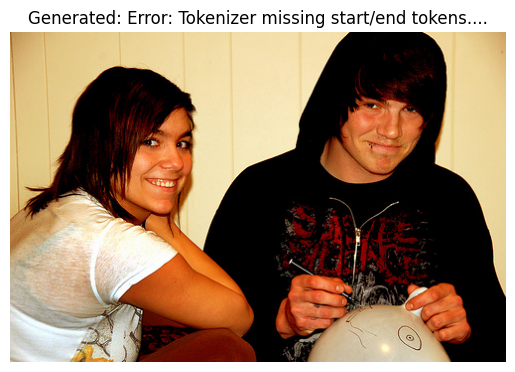


Original Captions:
- a boy pauses in drawing on a white balloon to smile at the camera and the girl next to him also smiles at the camera
- a brunette boy and girl smile for the camera while drawing faces on a white balloon
- a girl is smiling and a young man is drawing on a white balloon
- two smiling people with dark hair
- two young adults smile at the camera

--- Evaluating on Test Set (BLEU Score) ---


Evaluating Test Set:   0%|          | 0/404 [00:00<?, ?it/s]

Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error: <start> or <end> token index not found in tokenizer word_index.
Error:

In [ ]:
image_features = {}
captions_dict = {}
valid_image_ids_subset = []

if captions_dict_all:
    all_potential_ids = list(captions_dict_all.keys())
    print(f"\nFound {len(all_potential_ids)} unique image IDs mentioned in {CAPTIONS_PATH}.")
    valid_image_ids_all = [
        img_id for img_id in all_potential_ids
        if os.path.exists(os.path.join(IMAGES_PATH, img_id))
    ]
    print(f"Found {len(valid_image_ids_all)} corresponding image files in the '{os.path.basename(IMAGES_PATH)}' folder.")

    missing_count = len(all_potential_ids) - len(valid_image_ids_all)
    if missing_count > 0:
         print(f"Warning: {missing_count} image file(s) mentioned in captions.txt were NOT found in the Images folder.")

    if NUM_IMAGES_TO_USE is not None and NUM_IMAGES_TO_USE < len(valid_image_ids_all):
        print(f"Selecting a random subset of {NUM_IMAGES_TO_USE} images for processing.")
        random.seed(42)
        valid_image_ids_subset = random.sample(valid_image_ids_all, NUM_IMAGES_TO_USE)
    else:
        if NUM_IMAGES_TO_USE is not None:
            print(f"Using all {len(valid_image_ids_all)} available valid images (limit {NUM_IMAGES_TO_USE} >= available).")
        else:
             print(f"Using all {len(valid_image_ids_all)} available valid images (no limit set).")
        valid_image_ids_subset = valid_image_ids_all
    print(f"Processing will be based on {len(valid_image_ids_subset)} images.")
    captions_dict = {
        img_id: caps for img_id, caps in captions_dict_all.items()
        if img_id in valid_image_ids_subset # Filter based on the final selected list
    }
    print(f"Filtered captions dictionary to {len(captions_dict)} entries matching the selected image subset.")
    if valid_image_ids_subset:
        image_features = extract_features(
            IMAGES_PATH,
            valid_image_ids_subset, # Pass the final list of image IDs
            force_rerun=False,
            existing_features_path=FEATURES_PATH # Pass the path to check cache
        )
        image_features = {k: v for k, v in image_features.items() if k in valid_image_ids_subset}
        print(f"Retained features for {len(image_features)} images after extraction/loading.")
    else:
        print("Error: No images selected for processing. Check filters or image availability.")
        image_features = {}
        captions_dict = {}
else:
    print("Error: Cannot proceed as initial caption loading failed.")
    valid_image_ids_subset = [] # Ensure list exists and is empty

if image_features:
    try:
        first_key = list(image_features.keys())[0]
        FEATURE_DIM = image_features[first_key].shape[0]
        print(f"\nExtracted/Loaded Feature Dimension: {FEATURE_DIM}")
    except IndexError:
         print("\nWarning: Feature dictionary is empty after processing.")
         FEATURE_DIM = None
elif captions_dict:
     print("\nFeature extraction/loading skipped or failed. Cannot determine feature dimension.")
     FEATURE_DIM = None
else:
     FEATURE_DIM = None


# Prepare Data for Training (Tokenization, Padding, Splitting) (Uses filtered `captions_dict`)
def create_tokenizer_and_sequences(captions_dict_subset, vocab_size_limit, max_len_padding, tokenizer_save_path):
    if not captions_dict_subset:
         print("Error: Cannot create tokenizer because the captions dictionary subset is empty.")
         return None, None, None, None

    all_captions = []
    for key in captions_dict_subset:
        for caption in captions_dict_subset[key]:
            all_captions.append(caption)
    print(f"\nTotal number of captions for tokenization (from subset): {len(all_captions)}")

    tokenizer = Tokenizer(num_words=vocab_size_limit, oov_token="<unk>")
    tokenizer.fit_on_texts(all_captions)

    vocab_size = min(vocab_size_limit, len(tokenizer.word_index)) + 1
    print(f"Vocabulary Size (limit {vocab_size_limit}): {vocab_size}")

    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    sequences = tokenizer.texts_to_sequences(all_captions)
    max_actual_length = 0
    if sequences:
         max_actual_length = max(len(s) for s in sequences)
    print(f"Maximum actual sequence length found (in subset): {max_actual_length}")
    if max_len_padding < max_actual_length:
         print(f"Warning: Specified MAX_LENGTH_PADDING ({max_len_padding}) is less than actual max length ({max_actual_length}). Increasing max_length.")
         max_length = max_actual_length
    else:
         max_length = max_len_padding
    print(f"Using max sequence length: {max_length}")


    image_sequences = {}
    for img_id, caps in captions_dict_subset.items():
        if img_id in image_features: # Check based on available features
             seqs = tokenizer.texts_to_sequences(caps)
             image_sequences[img_id] = seqs

    if not image_sequences:
         print("Warning: No sequences generated. Check captions and feature consistency.")

    try:
        with open(tokenizer_save_path, 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Tokenizer saved to: {tokenizer_save_path}")
    except Exception as e:
        print(f"Error saving tokenizer: {e}")

    return tokenizer, vocab_size, max_length, image_sequences


if captions_dict: # Use the final filtered dict
    tokenizer, vocab_size, max_length, image_sequences = create_tokenizer_and_sequences(
        captions_dict,
        VOCAB_SIZE_LIMIT,
        MAX_LENGTH_PADDING,
        TOKENIZER_PATH # Pass specific save path
    )
    if tokenizer is None:
        print("Tokenizer creation failed.")
        vocab_size = None
        max_length = None
        image_sequences = None
else:
    print("Cannot create tokenizer as the final captions dictionary is empty.")
    tokenizer = None
    vocab_size = None
    max_length = None
    image_sequences = None


def create_data_pairs(image_features_subset, image_sequences_subset, max_len):
    data_list = []
    if not image_features_subset or not image_sequences_subset:
         print("Cannot create data pairs, features or sequences subset dictionary is empty.")
         return data_list

    for img_id, seqs in image_sequences_subset.items():
        if img_id in image_features_subset:
            feature = image_features_subset[img_id]
            for seq in seqs:
                # Teacher forcing: predict next word given previous words
                for i in range(1, len(seq)):
                    in_seq, out_word = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # Target 'out_word' is just the single word index
                    data_list.append({'feature': feature, 'in_seq': in_seq, 'out_word': out_word})
        else:
            print(f"Warning: Feature not found for image {img_id} during pair creation (should be consistent).")
    print(f"Created {len(data_list)} input-output pairs from subset for training.")
    return data_list


train_data_pairs = []
val_data_pairs = []
test_ids = []

if image_features and image_sequences: # Check if feature/sequence dicts for subset are non-empty
    all_data_pairs = create_data_pairs(image_features, image_sequences, max_length)
    # Use valid_image_ids_subset for splitting now
    if valid_image_ids_subset:
        num_samples = len(valid_image_ids_subset)
        if num_samples < 20: # Example threshold
             num_val = max(1, int(0.10 * num_samples)) # Ensure at least 1 val sample
             num_test = 0 # Skip test set for very small runs
        else:
            num_val = max(1, int(0.15 * num_samples))
            num_test = max(0, int(0.05 * num_samples)) # Allow zero test samples if needed


        np.random.seed(42)
        shuffled_ids = valid_image_ids_subset.copy()
        np.random.shuffle(shuffled_ids)

        # Handle potential overlaps if numbers are small
        val_ids = shuffled_ids[:num_val]
        test_ids = shuffled_ids[num_val : num_val + num_test]
        train_ids = shuffled_ids[num_val + num_test:]

        # Safety check: Ensure no overlap between train, val, test
        assert len(set(train_ids) & set(val_ids)) == 0
        assert len(set(train_ids) & set(test_ids)) == 0
        assert len(set(val_ids) & set(test_ids)) == 0

        print(f"\nSplitting {num_samples} selected image samples:")
        print(f"Train images: {len(train_ids)}, Validation images: {len(val_ids)}, Test images: {len(test_ids)}")


        def filter_pairs_by_id(allowed_ids, features_dict, sequences_dict, max_len):
              filtered_list = []
              if not allowed_ids: # Handle empty lists directly
                   return filtered_list
              for img_id in allowed_ids:
                   if img_id in features_dict and img_id in sequences_dict:
                       feature = features_dict[img_id]
                       seqs = sequences_dict[img_id]
                       for seq in seqs:
                           for i in range(1, len(seq)):
                               in_seq, out_word = seq[:i], seq[i]
                               in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                               filtered_list.append({'feature': feature, 'in_seq': in_seq, 'out_word': out_word})
              return filtered_list


        train_data_pairs = filter_pairs_by_id(train_ids, image_features, image_sequences, max_length)
        val_data_pairs = filter_pairs_by_id(val_ids, image_features, image_sequences, max_length)

        print(f"Train pairs created: {len(train_data_pairs)}, Validation pairs created: {len(val_data_pairs)}")
        if not train_data_pairs or not val_data_pairs:
             print("Warning: Train or validation data pair list is empty after filtering. Check splits and data.")

    else:
         print("Error: Cannot split data as no image IDs were selected for processing.")

else:
    print("\nCannot prepare training data pairs due to missing/empty features or sequences subset.")


# ==============================================
# Data Generator (No changes needed)
# ==============================================
class DataGenerator(Sequence):
    def __init__(self, data_pairs, batch_size, max_length, vocab_size, feature_dim, shuffle=True):
        self.data_pairs = data_pairs
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.feature_dim = feature_dim if feature_dim is not None else 0 # Handle None case
        self.shuffle = shuffle
        # Ensure feature_dim is valid before creating arrays
        if self.feature_dim <= 0:
             print(f"Warning: Invalid feature_dim ({self.feature_dim}) in DataGenerator. Data generation might fail.")

        # Filter out pairs with invalid features just in case
        self.data_pairs = [p for p in data_pairs if p['feature'].shape[0] == self.feature_dim] if self.feature_dim > 0 else []
        if len(self.data_pairs) != len(data_pairs):
             print(f"Warning: Removed {len(data_pairs) - len(self.data_pairs)} pairs with inconsistent feature dimensions.")

        self.indexes = np.arange(len(self.data_pairs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        if not self.data_pairs or self.batch_size <= 0:
            return 0
        return int(np.floor(len(self.data_pairs) / self.batch_size))

    def __getitem__(self, index):
        if len(self) == 0:
            raise IndexError("Generator length is zero.")

        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Check if batch_indexes is empty, although __len__ should prevent this call
        if len(batch_indexes) == 0:
              # This should ideally not happen if __len__ > 0
              print("Warning: Attempting to get item with empty batch_indexes.")
              # Return empty arrays with correct shapes
              return [np.zeros((0, self.feature_dim)), np.zeros((0, self.max_length), dtype='int32')], np.zeros((0,), dtype='int32')


        batch_pairs = [self.data_pairs[k] for k in batch_indexes]
        current_batch_size = len(batch_pairs) # Use actual number of pairs for this batch

        # Initialize arrays with the actual batch size
        X_features = np.zeros((current_batch_size, self.feature_dim))
        X_seq = np.zeros((current_batch_size, self.max_length), dtype='int32')
        y_word = np.zeros((current_batch_size,), dtype='int32')

        for i, pair in enumerate(batch_pairs):
            # Added check for feature dimension consistency within the batch generation
            if pair['feature'].shape[0] == self.feature_dim:
                X_features[i, :] = pair['feature']
                X_seq[i, :] = pair['in_seq']
                y_word[i] = pair['out_word']
            else:
                 print(f"Error in batch generation: Feature dim mismatch. Expected {self.feature_dim}, got {pair['feature'].shape}. Skipping pair.")
                 # How to handle this? Could shrink the batch, but simpler might be to zero out this entry
                 # This might affect training negatively. Filtering upstream is better.
                 pass # Entry remains zero

        # Use sparse categorical crossentropy, so y_word is just indices
                # Return a dictionary for inputs, matching the Input layer names
        return {'image_features': X_features, 'caption_input': X_seq}, y_word


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


# ==============================================
# Build the Encoder-Decoder Model (No changes needed)
# ==============================================
def build_captioning_model(feature_dim, max_length, vocab_size, embedding_dim, units, dropout_rate, rnn_lstm_dropout, decoder_type='lstm'):
    inputs1 = Input(shape=(feature_dim,), name='image_features')
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(units, activation='relu')(fe1) # Project feature to state size

    inputs2 = Input(shape=(max_length,), name='caption_input')
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # mask_zero ignores padding
    se2 = Dropout(dropout_rate)(se1)

    # Decoder layer (returns only last state for single word prediction)
    if decoder_type.lower() == 'rnn':
        print("Building SimpleRNN model for single word prediction.")
        decoder_layer = SimpleRNN(units, dropout=rnn_lstm_dropout, recurrent_dropout=rnn_lstm_dropout)(se2, initial_state=fe2)
    elif decoder_type.lower() == 'lstm':
        print("Building LSTM model for single word prediction.")
        # LSTM initial state is a list: [hidden_state, cell_state]
        lstm_out, _, _ = LSTM(units, return_state=True, dropout=rnn_lstm_dropout, recurrent_dropout=rnn_lstm_dropout)(se2, initial_state=[fe2, fe2])
        decoder_layer = lstm_out # Use the hidden state output of the last time step
    else:
         raise ValueError("Invalid decoder_type. Choose 'rnn' or 'lstm'.")

    # Output layer predicts next word probability distribution
    outputs = Dense(vocab_size, activation='softmax')(decoder_layer)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs, name=f'image_captioning_{decoder_type}')
    # Compile using sparse categorical crossentropy since targets are single indices
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(f"\n--- Model Summary ({decoder_type.upper()}) ---")
    model.summary()
    return model


# ==============================================
# Training (Check for valid FEATURE_DIM, vocab_size, max_length)
# ==============================================
model = None
history = None
# Build model only if essential dimensions are valid
if FEATURE_DIM and vocab_size and max_length:
    model = build_captioning_model(
        feature_dim=FEATURE_DIM,
        max_length=max_length,
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        units=UNITS,
        dropout_rate=DROPOUT_RATE,
        rnn_lstm_dropout=RNN_LSTM_DROPOUT,
        decoder_type=DECODER_TYPE
    )
else:
    print("Cannot build model due to missing/invalid configuration (FEATURE_DIM, vocab_size, max_length). Check previous steps.")


if model and train_data_pairs and val_data_pairs: # Also check if data pairs lists are non-empty

    train_generator = DataGenerator(train_data_pairs, BATCH_SIZE, max_length, vocab_size, FEATURE_DIM)
    val_generator = DataGenerator(val_data_pairs, BATCH_SIZE, max_length, vocab_size, FEATURE_DIM, shuffle=False)

    if len(train_generator) == 0 or len(val_generator) == 0:
         print("\nError: Training or validation generator has zero length. Cannot train.")
         print(f"Number of train pairs: {len(train_data_pairs)}, Val pairs: {len(val_data_pairs)}, Batch size: {BATCH_SIZE}")
    else:
        print(f"\nTrain generator length: {len(train_generator)} batches")
        print(f"Validation generator length: {len(val_generator)} batches")

        checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

        print("\n--- Starting Training ---")
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=val_generator,
            callbacks=[checkpoint, early_stopping]
            # workers and use_multiprocessing arguments removed
        )
        print("\n--- Training Finished ---")

        if history: # Plot only if training occurred
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.tight_layout()
            plt.show()

else:
    print("\nCannot start training. Model not built or data pair lists are empty.")


# ==============================================
# Caption Generation (Inference) (No changes needed in function definition)
# ==============================================
def generate_caption(model, tokenizer, image_feature, max_length, decoder_type='lstm'):
    start_token_index = tokenizer.word_index.get('<start>', None)
    end_token_index = tokenizer.word_index.get('<end>', None)
    pad_token_index = tokenizer.word_index.get('<pad>', 0)

    if start_token_index is None or end_token_index is None:
        print("Error: <start> or <end> token index not found in tokenizer word_index.")
        return "Error: Tokenizer missing start/end tokens."

    in_seq_indices = [start_token_index]

    for _ in range(max_length):
        padded_seq = pad_sequences([in_seq_indices], maxlen=max_length, padding='post')[0]
        input_seq = np.array([padded_seq])
        input_feature = np.array([image_feature]) # Add batch dimension
        try:
            yhat = model.predict([input_feature, input_seq], verbose=0)
            predicted_index = np.argmax(yhat)
        except Exception as e:
             print(f"Error during model prediction in generation: {e}")
             return "Error: Prediction failed."

        if predicted_index == end_token_index or predicted_index == pad_token_index:
            break

        in_seq_indices.append(predicted_index)
    final_caption_words = [tokenizer.index_word.get(idx, '<unk>') for idx in in_seq_indices]
    caption_out = []
    for word in final_caption_words:
         if word == '<start>':
             continue
         if word == '<end>':
             break
         caption_out.append(word)

    return ' '.join(caption_out)


# ==============================================
# Load Inference Assets (No changes needed in function definition)
# ==============================================
def load_inference_assets(model_path, tokenizer_path):
    inference_model = None
    inference_tokenizer = None
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
    else:
        try:
            inference_model = tf.keras.models.load_model(model_path)
            print(f"Model loaded from {model_path}")
        except Exception as e:
            print(f"Error loading model from {model_path}: {e}")

    if not os.path.exists(tokenizer_path):
         print(f"Error: Tokenizer file not found at {tokenizer_path}")
    else:
        try:
            with open(tokenizer_path, 'rb') as handle:
                inference_tokenizer = pickle.load(handle)
            print(f"Tokenizer loaded from {tokenizer_path}")
        except Exception as e:
            print(f"Error loading tokenizer from {tokenizer_path}: {e}")

    return inference_model, inference_tokenizer


# ==============================================
# Example Usage & Evaluation (Uses `test_ids` from split)
# ==============================================
inference_model, inference_tokenizer = load_inference_assets(MODEL_SAVE_PATH, TOKENIZER_PATH)
if inference_model and inference_tokenizer and image_features:
    sampling_ids = []
    if 'test_ids' in locals() and test_ids:
        sampling_ids.extend(test_ids)
    if 'val_ids' in locals() and val_ids:
         sampling_ids.extend(val_ids)

    if not sampling_ids:
         sampling_ids = list(image_features.keys())
         if sampling_ids:
              print("Warning: No validation/test IDs available. Sampling from all processed images.")
         else:
              print("Warning: No images available to sample for caption generation.")

    if sampling_ids:
        sample_image_id = random.choice(sampling_ids) # Use random.choice
        sample_image_path = os.path.join(IMAGES_PATH, sample_image_id)

        if sample_image_id in image_features:
            print(f"\n--- Generating Caption for Image: {sample_image_id} ---")
            sample_feature = image_features[sample_image_id]
            generated_caption = generate_caption(inference_model, inference_tokenizer, sample_feature, max_length, DECODER_TYPE)

            print(f"Generated Caption: {generated_caption}")
            try:
                if os.path.exists(sample_image_path):
                    image = Image.open(sample_image_path)
                    plt.imshow(image)
                    plt.title(f"Generated: {generated_caption[:60]}...")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"Cannot display image, file not found: {sample_image_path}")
            except Exception as e:
                print(f"Error displaying image: {e}")

            if captions_dict and sample_image_id in captions_dict:
                print("\nOriginal Captions:")
                original_caps = captions_dict.get(sample_image_id, [])
                for cap in original_caps:
                    display_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"- {display_cap}")
            else:
                 print("\nCould not retrieve original captions for comparison (check final captions dict).")
        else:
            print(f"Error: Feature for sampled image '{sample_image_id}' not found in the final feature set.")
    else:
        print("\nCould not run example usage: No image IDs available for sampling.")

else:
    print("\nCould not run example usage. Inference model, tokenizer, or features failed to load/initialize.")


# --- Optional: Evaluate on Test Set using BLEU ---
if inference_model and inference_tokenizer and 'test_ids' in locals() and test_ids and captions_dict and image_features:
    print("\n--- Evaluating on Test Set (BLEU Score) ---")
    actual, predicted = list(), list()
    evaluation_count = 0

    for image_id in tqdm(test_ids, desc="Evaluating Test Set"):
        if image_id in image_features:
            feature = image_features[image_id]
            gen_cap = generate_caption(inference_model, inference_tokenizer, feature, max_length, DECODER_TYPE)

            # Get actual captions from the FINAL filtered captions_dict
            references = captions_dict.get(image_id, [])
            if not references: continue # Skip if no reference captions found for this test ID

            # Clean references for BLEU score (list of lists of words)
            cleaned_references = [
                [word for word in cap.replace('<start>', '').replace('<end>', '').strip().split() if word]
                for cap in references
            ]
            # Remove empty lists from cleaned_references if any caption becomes empty after cleaning
            cleaned_references = [ref for ref in cleaned_references if ref]


            if cleaned_references: # Only score if we have valid references
                actual.append(cleaned_references)
                predicted.append([word for word in gen_cap.split() if word]) # Ensure generated caption is list of words
                evaluation_count += 1

    if actual and predicted:
        # Calculate BLEU scores
        bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
        bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

        print(f"\nBLEU Scores on Test Set ({evaluation_count} images evaluated):")
        print(f'BLEU-1: {bleu1*100:.2f}')
        print(f'BLEU-2: {bleu2*100:.2f}')
        print(f'BLEU-3: {bleu3*100:.2f}')
        print(f'BLEU-4: {bleu4*100:.2f}')
    elif evaluation_count > 0 :
         print("BLEU score calculation failed: No valid actual references or predicted captions were collected.")
    else:
         print("No test images were evaluated (check test_ids and feature availability).")

elif not ('test_ids' in locals() and test_ids):
    print("\nSkipping BLEU evaluation: Test set is empty or undefined.")
else:
     print("\nSkipping BLEU evaluation: Missing inference model, tokenizer, or other data.")


print("\n--- Script Finished ---")